In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from keras.utils import plot_model

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('/content/Restaurants_Train_v2.csv')

In [3]:
df.head()

,id,Sentence,Aspect Term,polarity,from,to
0,3121,But the staff was so horrible to us.,staff,negative,8,13
1,2777,"To be completely fair, the only redeeming fact...",food,positive,57,61
2,1634,"The food is uniformly exceptional, with a very...",food,positive,4,8
3,1634,"The food is uniformly exceptional, with a very...",kitchen,positive,55,62
4,1634,"The food is uniformly exceptional, with a very...",menu,neutral,141,145


+ Remove the from to columns
+ check different values of polarity
+ check for null values

In [ ]:
df = df.drop(['from', 'to'], axis=1)
print(df['polarity'].unique())
print(df.isna().sum())

['negative' 'positive' 'neutral' 'conflict']
id             0
Sentence       0
Aspect Term    0
polarity       0
dtype: int64


+ Get rows of dataset except those with conflict in polarity
+ Convert polarity labels to numeric

In [ ]:
con = (df['polarity'] == 'conflict')
df = df[~con]
polarity_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
df['polarity'] = df['polarity'].map(polarity_mapping)

<ipython-input-36-60cbb7c3555c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['polarity'] = df['polarity'].map(polarity_mapping)


In [ ]:
def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    clean_text = re.sub(pattern, '', text)
    return clean_text

def lemmatize_tokenized_text(tokenized_text):
  lemmatizer = WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokenized_text]
  return lemmatized_tokens

+ Lower the review text and remove special characters
+ Tokenize the clean text
+ lemmatize the tokenized text

In [ ]:
df['clean_text'] = df['Sentence'].str.lower().apply(remove_special_characters)
df['Tokenized_text'] = df['clean_text'].apply(word_tokenize)
df['Lemmatized_text'] = df['Tokenized_text'].apply(lemmatize_tokenized_text)
df['Aspect Term']= df['Aspect Term'].str.lower().apply(remove_special_characters)

In [ ]:
def join_list_to_text(text_list):
  return ' '.join([word for word in text_list])

df['join_text'] = df['Lemmatized_text'].apply(join_list_to_text)


In [ ]:
def get_nouns(sentence):
    words = word_tokenize(sentence)
    tagged_words = pos_tag(words)
    nouns = [word for word, pos in tagged_words if pos.startswith('N')]
    return nouns

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize



vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Aspect Term'])

cosine_dist_matrix = cosine_distances(X)


num_clusters = 25
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(cosine_dist_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
grouped_df = df.groupby('cluster')['Aspect Term'].apply(list)

for cluster, words in grouped_df.items():
    print(f"Cluster {cluster}:", words)

Cluster 0: ['kitchen', 'perks', 'orrechiete with sausage and chicken', 'waiters', 'meats', 'bagels', 'toast', 'mayonnaise', 'bacon', 'cheese', 'ingredients', 'plate', 'omelet', 'check', 'design', 'cuisine', 'thin crusted pizza', 'interior decoration', 'chefs', 'seats', 'seltzer with lime', 'pickles', 'selection of meats and seafoods', 'eat family style', 'vibe', 'owner', 'delivery', 'quantity', 'fried rice', 'mussels', 'puff pastry goat cheese', 'salad with a delicious dressing', 'hanger steak au poivre', 'courses', 'broth with noodles', 'money', 'specials', 'dine', 'desert', 'environment', 'lasagnette appetizer', 'beer selection', 'setting', 'dining', 'dosa', 'winebytheglass', 'entrees', 'sake martini', 'bagels', 'spreads', 'ingredients', 'chopsticks', 'garden terrace', 'cuisine', 'crowded', 'grilled branzino', 'vibe', 'packed', 'delivery', 'order', 'server', 'scents', 'lobster sandwich', 'check', 'shell crab', 'deep fried skewers', 'reservations', 'hostess', 'congee rice porridge', '

In [ ]:
cluster_mapping = {'Food': [1, 4, 6, 8, 11, 13, 14, 19, 21, 22, 23],
                   'Service': [2, 3, 9, 17],
                   'Ambiance': [5, 15, 20, 24],
                   'Price': [7, 12],
                   'Drinks': [10, 16, 18],
                   'General': [0]}

df['cluster'] = df['cluster'].map({cluster: category for category, clusters in cluster_mapping.items() for cluster in clusters})

In [ ]:
df.head()

,id,Sentence,Aspect Term,polarity,clean_text,Tokenized_text,Lemmatized_text,join_text,cluster
0,3121,But the staff was so horrible to us.,staff,0,but the staff was so horrible to us,"[but, the, staff, was, so, horrible, to, us]","[but, the, staff, wa, so, horrible, to, u]",but the staff wa so horrible to u,Service
1,2777,"To be completely fair, the only redeeming fact...",food,2,to be completely fair the only redeeming facto...,"[to, be, completely, fair, the, only, redeemin...","[to, be, completely, fair, the, only, redeemin...",to be completely fair the only redeeming facto...,Food
2,1634,"The food is uniformly exceptional, with a very...",food,2,the food is uniformly exceptional with a very ...,"[the, food, is, uniformly, exceptional, with, ...","[the, food, is, uniformly, exceptional, with, ...",the food is uniformly exceptional with a very ...,Food
3,1634,"The food is uniformly exceptional, with a very...",kitchen,2,the food is uniformly exceptional with a very ...,"[the, food, is, uniformly, exceptional, with, ...","[the, food, is, uniformly, exceptional, with, ...",the food is uniformly exceptional with a very ...,General
4,1634,"The food is uniformly exceptional, with a very...",menu,1,the food is uniformly exceptional with a very ...,"[the, food, is, uniformly, exceptional, with, ...","[the, food, is, uniformly, exceptional, with, ...",the food is uniformly exceptional with a very ...,Food


<Axes: xlabel='polarity', ylabel='count'>

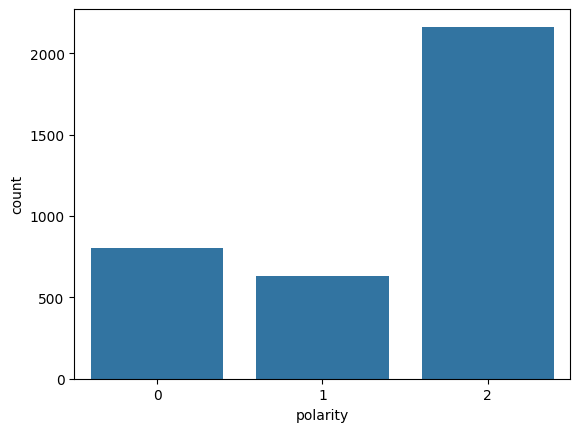

In [ ]:
sns.countplot(x='polarity', data=df)

Aspect Category Model

In [ ]:
X = df['Aspect Term']
y = df['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder_aspect = LabelEncoder()
y_train_encoded = label_encoder_aspect.fit_transform(y_train)
y_test_encoded = label_encoder_aspect.transform(y_test)


tokenizer_aspect = Tokenizer()
tokenizer_aspect.fit_on_texts(X_train)
X_train_seq = tokenizer_aspect.texts_to_sequences(X_train.values)
X_test_seq = tokenizer_aspect.texts_to_sequences(X_test.values)

max_sequence_length = max(max(len(sequence) for sequence in X_train_seq),
                        max(len(sequence) for sequence in X_test_seq))

X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)


num_categories = 6
y_train_encoded_onehot = to_categorical(y_train_encoded, num_categories)
y_test_encoded_onehot = to_categorical(y_test_encoded, num_categories)


class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weight_dict = dict(enumerate(class_weights))

vocab_size = len(tokenizer.word_index) + 1

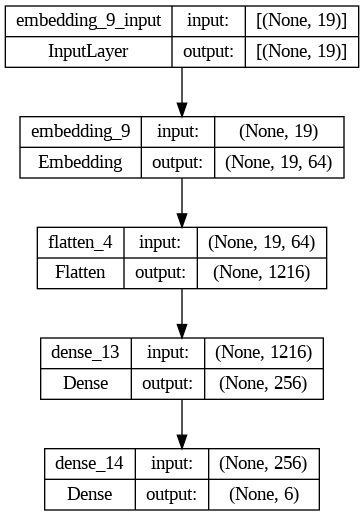

In [ ]:
aspect_category_model = Sequential()
aspect_category_model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_sequence_length))
aspect_category_model.add(Flatten())
aspect_category_model.add(Dense(256, activation='relu'))
aspect_category_model.add(Dense(num_categories, activation='softmax'))
aspect_category_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

plot_model(aspect_category_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
batch_size = 32
aspect_category_model_history = aspect_category_model.fit(
    X_train_padded,
    y_train_encoded_onehot,
    epochs=5,
    batch_size=batch_size,
    validation_split=0.1,
    class_weight=class_weight_dict
)


loss, accuracy = aspect_category_model.evaluate(X_test_padded, y_test_encoded_onehot)
print(f'Accuracy: {accuracy * 100:.2f}%')

Epoch 1/5
81/81 [==============================] - 1s 11ms/step - loss: 1.5444 - accuracy: 0.4707 - val_loss: 1.2019 - val_accuracy: 0.5952
Epoch 2/5
81/81 [==============================] - 1s 9ms/step - loss: 0.3984 - accuracy: 0.9579 - val_loss: 0.1645 - val_accuracy: 0.9896
Epoch 3/5
81/81 [==============================] - 1s 10ms/step - loss: 0.0654 - accuracy: 0.9907 - val_loss: 0.0810 - val_accuracy: 0.9931
Epoch 4/5
81/81 [==============================] - 1s 14ms/step - loss: 0.0259 - accuracy: 0.9931 - val_loss: 0.0452 - val_accuracy: 0.9965
Epoch 5/5
23/23 [==============================] - 0s 4ms/step - loss: 0.0517 - accuracy: 0.9917
Accuracy: 99.17%


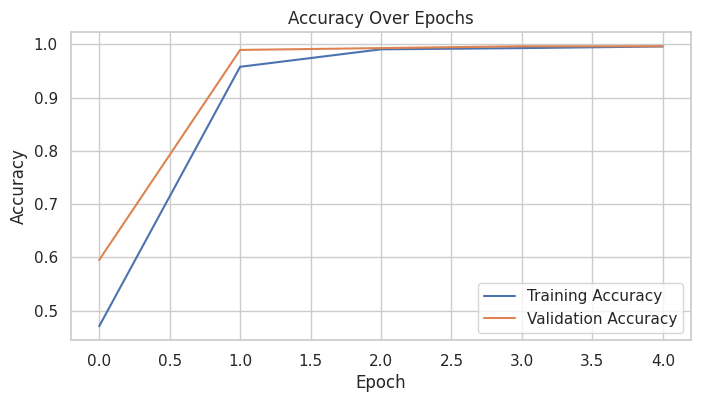

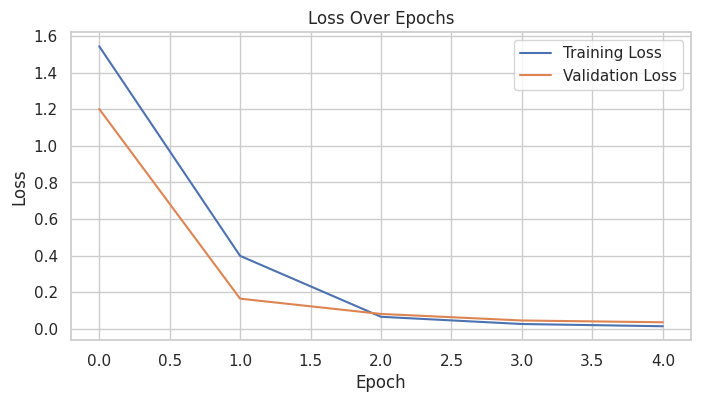

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(aspect_category_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(aspect_category_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(aspect_category_model_history.history['loss'], label='Training Loss')
plt.plot(aspect_category_model_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

In [ ]:
y_pred_probabilities = aspect_category_model.predict(X_test_padded)
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)


y_test_decoded = label_encoder.inverse_transform(y_test_encoded)
y_pred_decoded = label_encoder.inverse_transform(y_pred_labels)


f1_aspect_category = f1_score(y_test_decoded, y_pred_decoded, average='weighted')


accuracy_aspect_category = accuracy_score(y_test_decoded, y_pred_decoded)


precision_aspect_category = precision_score(y_test_decoded, y_pred_decoded, average='weighted')


recall_aspect_category = recall_score(y_test_decoded, y_pred_decoded, average='weighted')

print(f'F1 Score: {f1_aspect_category:.2f}')
print(f'Accuracy: {accuracy_aspect_category:.2f}')
print(f'Precision: {precision_aspect_category:.2f}')
print(f'Recall: {recall_aspect_category:.2f}')


23/23 [==============================] - 0s 2ms/step
F1 Score: 0.99
Accuracy: 0.99
Precision: 0.99
Recall: 0.99


In [ ]:
def extract_pos_tags_as_string(sentence):

    stop_words = set(stopwords.words('english'))


    tokens = word_tokenize(sentence)
    tagged_tokens = pos_tag(tokens)


    result_string = ""
    for word, pos in tagged_tokens:
        if (pos.startswith('VB') or pos.startswith('JJ') or pos.startswith('RB')) and word not in stop_words:
            result_string += word + " "


    return result_string.strip()

In [ ]:
df['extracted_words'] = df['clean_text'].apply(extract_pos_tags_as_string)

In [ ]:
df.head(10)

,id,Sentence,Aspect Term,polarity,clean_text,Tokenized_text,Lemmatized_text,join_text,cluster,extracted_words
0,3121,But the staff was so horrible to us.,staff,0,but the staff was so horrible to us,"[but, the, staff, was, so, horrible, to, us]","[but, the, staff, wa, so, horrible, to, u]",but the staff wa so horrible to u,Service,horrible
1,2777,"To be completely fair, the only redeeming fact...",food,2,to be completely fair the only redeeming facto...,"[to, be, completely, fair, the, only, redeemin...","[to, be, completely, fair, the, only, redeemin...",to be completely fair the only redeeming facto...,Food,completely fair make
2,1634,"The food is uniformly exceptional, with a very...",food,2,the food is uniformly exceptional with a very ...,"[the, food, is, uniformly, exceptional, with, ...","[the, food, is, uniformly, exceptional, with, ...",the food is uniformly exceptional with a very ...,Food,uniformly exceptional capable proudly whip fee...
3,1634,"The food is uniformly exceptional, with a very...",kitchen,2,the food is uniformly exceptional with a very ...,"[the, food, is, uniformly, exceptional, with, ...","[the, food, is, uniformly, exceptional, with, ...",the food is uniformly exceptional with a very ...,General,uniformly exceptional capable proudly whip fee...
4,1634,"The food is uniformly exceptional, with a very...",menu,1,the food is uniformly exceptional with a very ...,"[the, food, is, uniformly, exceptional, with, ...","[the, food, is, uniformly, exceptional, with, ...",the food is uniformly exceptional with a very ...,Food,uniformly exceptional capable proudly whip fee...
5,2846,"Not only was the food outstanding, but the lit...",food,2,not only was the food outstanding but the litt...,"[not, only, was, the, food, outstanding, but, ...","[not, only, wa, the, food, outstanding, but, t...",not only wa the food outstanding but the littl...,Food,outstanding little great
6,2846,"Not only was the food outstanding, but the lit...",perks,2,not only was the food outstanding but the litt...,"[not, only, was, the, food, outstanding, but, ...","[not, only, wa, the, food, outstanding, but, t...",not only wa the food outstanding but the littl...,General,outstanding little great
7,1458,Our agreed favorite is the orrechiete with sau...,orrechiete with sausage and chicken,2,our agreed favorite is the orrechiete with sau...,"[our, agreed, favorite, is, the, orrechiete, w...","[our, agreed, favorite, is, the, orrechiete, w...",our agreed favorite is the orrechiete with sau...,General,agreed orrechiete chicken usually enough split...
8,1458,Our agreed favorite is the orrechiete with sau...,waiters,2,our agreed favorite is the orrechiete with sau...,"[our, agreed, favorite, is, the, orrechiete, w...","[our, agreed, favorite, is, the, orrechiete, w...",our agreed favorite is the orrechiete with sau...,General,agreed orrechiete chicken usually enough split...
9,1458,Our agreed favorite is the orrechiete with sau...,meats,1,our agreed favorite is the orrechiete with sau...,"[our, agreed, favorite, is, the, orrechiete, w...","[our, agreed, favorite, is, the, orrechiete, w...",our agreed favorite is the orrechiete with sau...,General,agreed orrechiete chicken usually enough split...


In [ ]:
X = df['extracted_words'] +  df['clean_text']
y = df['polarity']

In [ ]:
label_encoder = LabelEncoder()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(class_weight='balanced'))
])

# Define the parameter grid for grid search
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (5, 5)],
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train_encoded)

# Print Best Parameters
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'svm__C': 1, 'svm__kernel': 'rbf', 'tfidf__ngram_range': (1, 2)}


Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.56      0.58       161
           1       0.47      0.48      0.47       132
           2       0.81      0.83      0.82       428

    accuracy                           0.71       721
   macro avg       0.63      0.62      0.63       721
weighted avg       0.70      0.71      0.71       721



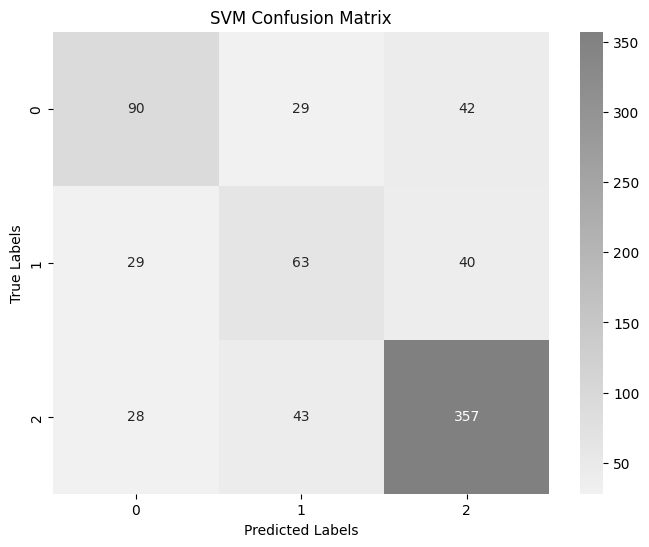

In [ ]:
y_pred = grid_search.best_estimator_.predict(X_test)

# Transform predicted labels back to original classes
y_pred_original = label_encoder.inverse_transform(y_pred)


accuracy_svm = accuracy_score(y_test, y_pred_original)
f1_svm = f1_score(y_test, y_pred_original, average='weighted')
precision_svm = precision_score(y_test, y_pred_original, average='weighted')
recall_svm = recall_score(y_test, y_pred_original, average='weighted')

# Convert label_encoder.classes_ to a list of strings
class_names = [str(class_name) for class_name in label_encoder.classes_]

# Use class_names in the classification_report
classification_rep = classification_report(y_test, y_pred_original, target_names=class_names)
print("Classification Report:\n", classification_rep)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_original)

light_gray_cmap = sns.light_palette("grey", as_cmap=True)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=light_gray_cmap, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

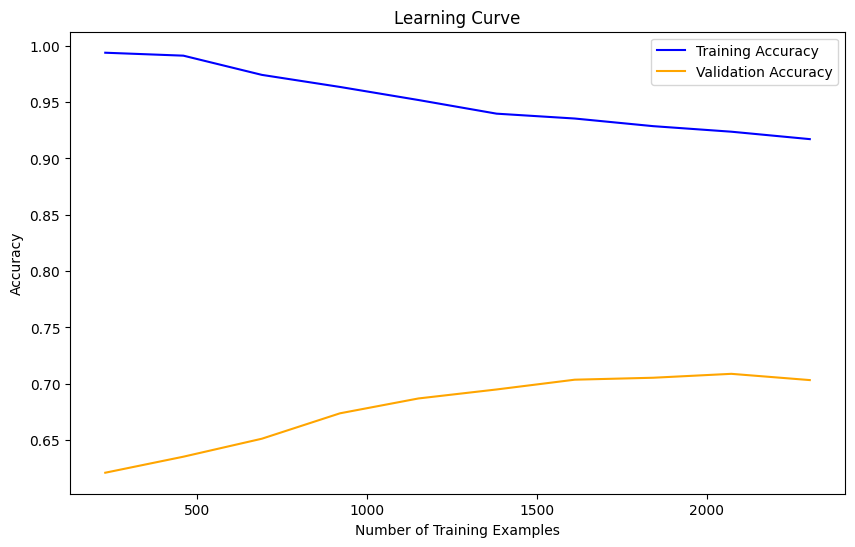

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_, X_train, y_train_encoded, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Calculate mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Validation Accuracy', color='orange')

plt.title('Learning Curve')
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()


In [ ]:
accuracy_svm = accuracy_score(y_test, y_pred_original)
f1_svm = f1_score(y_test, y_pred_original, average='weighted')
precision_svm = precision_score(y_test, y_pred_original, average='weighted')
recall_svm = recall_score(y_test, y_pred_original, average='weighted')

print(f'F1 Score: {f1_svm:.2f}')
print(f'Accuracy: {accuracy_svm:.2f}')
print(f'Precision: {precision_svm:.2f}')
print(f'Recall: {recall_svm:.2f}')


F1 Score: 0.71
Accuracy: 0.71
Precision: 0.70
Recall: 0.71


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)


X_train_seq = tokenizer.texts_to_sequences(X_train.values)
X_test_seq = tokenizer.texts_to_sequences(X_test.values)

max_sequence_length = max(len(sequence) for sequence in X_train_seq)


X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

y_train_encoded = to_categorical(y_train, num_classes=3)

y_test_encoded = to_categorical(y_test, num_classes=3)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 80, 100)           508600    
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_10 (Dense)            (None, 3)                 303       
                                                                 
Total params: 589303 (2.25 MB)
Trainable params: 589303 (2.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


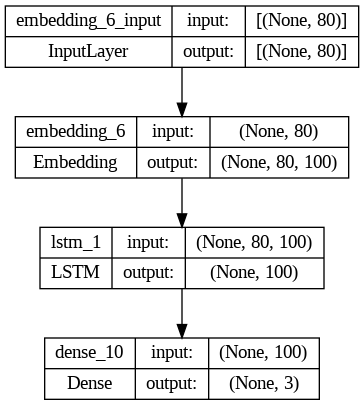

In [ ]:
class_weight_dict = dict(enumerate(class_weights))
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
batch_size=128
epochs = 5

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=100))
model.add(Dense(units=3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model
lstm_model = model.fit(X_train_padded, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.1, class_weight=class_weight_dict)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f'Accuracy: {accuracy * 100:.2f}%')

Epoch 1/5
21/21 [==============================] - 6s 211ms/step - loss: 1.0897 - accuracy: 0.5309 - val_loss: 1.0427 - val_accuracy: 0.5986
Epoch 2/5
21/21 [==============================] - 6s 272ms/step - loss: 0.9581 - accuracy: 0.6547 - val_loss: 0.7832 - val_accuracy: 0.6713
Epoch 3/5
21/21 [==============================] - 4s 194ms/step - loss: 0.6918 - accuracy: 0.7809 - val_loss: 0.7757 - val_accuracy: 0.6886
Epoch 4/5
21/21 [==============================] - 4s 194ms/step - loss: 0.4983 - accuracy: 0.8515 - val_loss: 0.8966 - val_accuracy: 0.6644
Epoch 5/5
23/23 [==============================] - 0s 20ms/step - loss: 0.8885 - accuracy: 0.6727
Accuracy: 67.27%


23/23 [==============================] - 1s 20ms/step


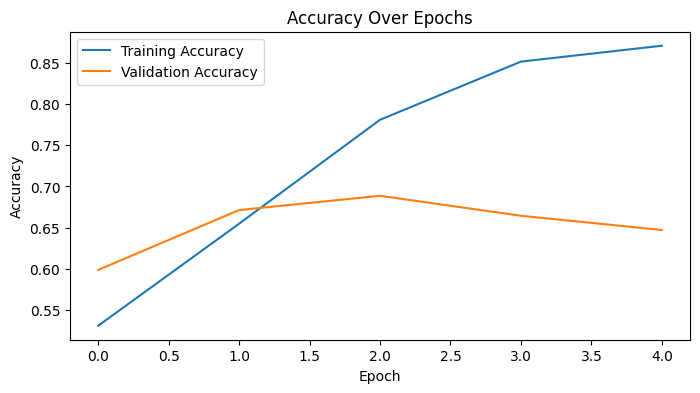

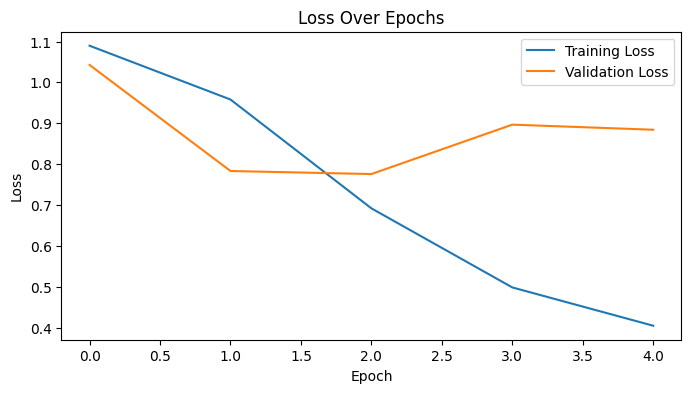

23/23 [==============================] - 1s 23ms/step


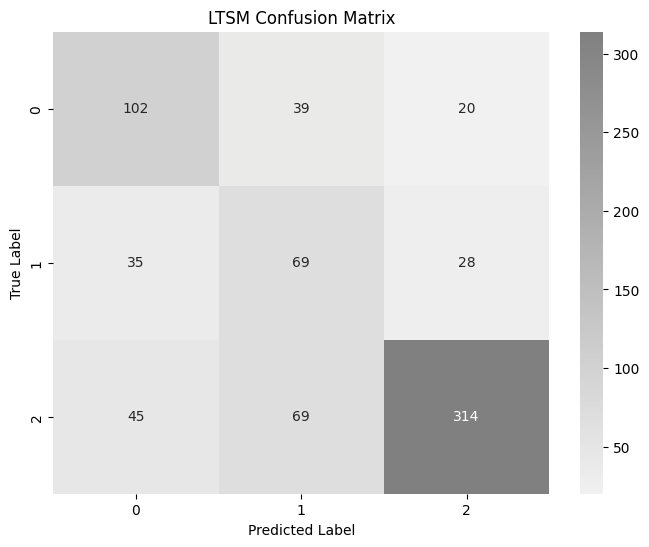

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.63      0.59       161
           1       0.39      0.52      0.45       132
           2       0.87      0.73      0.79       428

    accuracy                           0.67       721
   macro avg       0.61      0.63      0.61       721
weighted avg       0.71      0.67      0.69       721



In [ ]:

y_pred_probs = model.predict(X_test_padded)
y_true_labels = np.argmax(y_test_encoded, axis=1)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Plot Accuracy Over Epochs
plt.figure(figsize=(8, 4))
plt.plot(lstm_model.history['accuracy'], label='Training Accuracy')
plt.plot(lstm_model.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

# Plot Loss Over Epochs
plt.figure(figsize=(8, 4))
plt.plot(lstm_model.history['loss'], label='Training Loss')
plt.plot(lstm_model.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# Plot Confusion Matrix
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=light_gray_cmap, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LTSM Confusion Matrix')
plt.show()

# Convert class indices to strings
class_names = [str(label) for label in label_encoder.classes_]

# Print Classification Report
classification_rep = classification_report(y_true_labels, y_pred_labels, target_names=class_names)
print("Classification Report:")
print(classification_rep)


In [ ]:
f1_lstm = f1_score(y_true_labels, y_pred_labels, average='weighted')
accuracy_lstm = accuracy_score(y_true_labels, y_pred_labels)
precision_lstm = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall_lstm = recall_score(y_true_labels, y_pred_labels, average='weighted')

In [ ]:
# Build the CNN model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 80, 100)           508600    
                                                                 
 conv1d_2 (Conv1D)           (None, 78, 64)            19264     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_12 (Dense)            (None, 3)                 195       
                                                                 
Total params: 528059 (2.01 MB)
Trainable params: 528059 (2.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


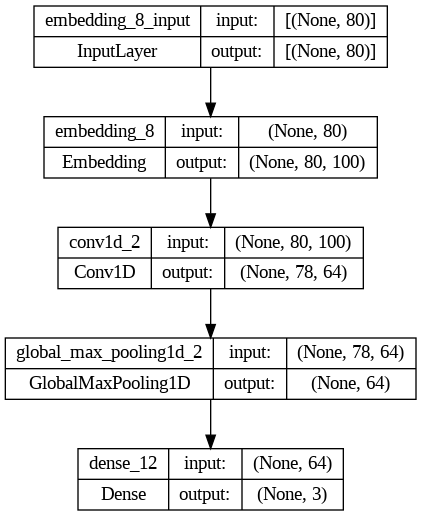

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model
cnn_model = model.fit(X_train_padded, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.1, class_weight=class_weight_dict)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f'Accuracy: {accuracy * 100:.2f}%')

Epoch 1/5
21/21 [==============================] - 2s 55ms/step - loss: 1.0854 - accuracy: 0.3731 - val_loss: 1.0643 - val_accuracy: 0.5848
Epoch 2/5
21/21 [==============================] - 1s 45ms/step - loss: 1.0081 - accuracy: 0.8052 - val_loss: 1.0052 - val_accuracy: 0.6713
Epoch 3/5
21/21 [==============================] - 1s 47ms/step - loss: 0.9172 - accuracy: 0.8476 - val_loss: 0.9199 - val_accuracy: 0.7197
Epoch 4/5
21/21 [==============================] - 1s 44ms/step - loss: 0.7890 - accuracy: 0.8596 - val_loss: 0.8053 - val_accuracy: 0.7232
Epoch 5/5
23/23 [==============================] - 0s 4ms/step - loss: 0.7458 - accuracy: 0.7060
Accuracy: 70.60%


23/23 [==============================] - 0s 4ms/step


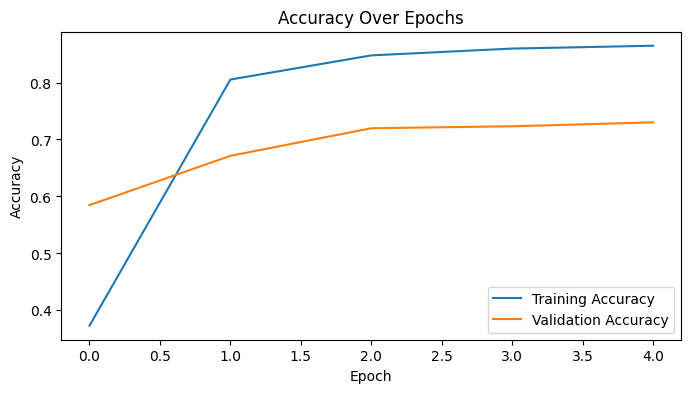

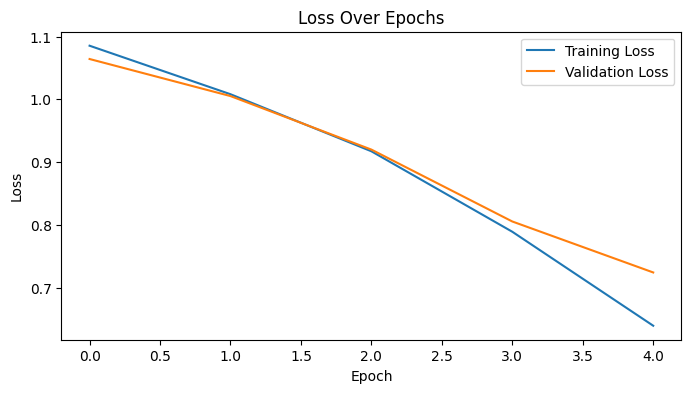

23/23 [==============================] - 0s 4ms/step


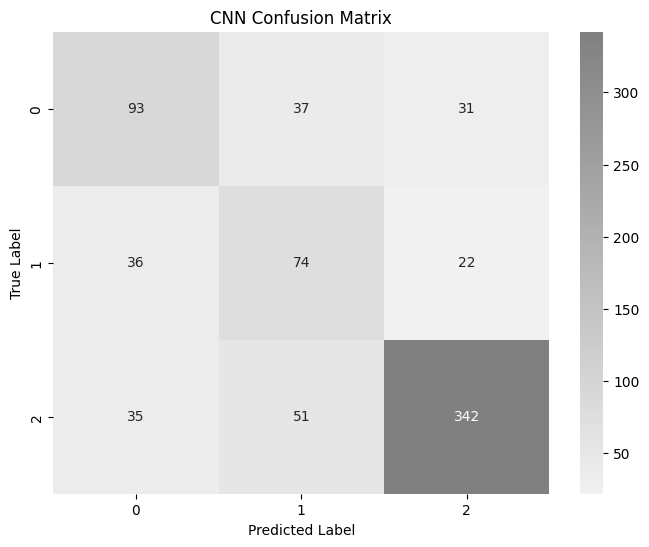

Classification Report:
              precision    recall  f1-score   support

    Negative       0.57      0.58      0.57       161
     Neutral       0.46      0.56      0.50       132
    Positive       0.87      0.80      0.83       428

    accuracy                           0.71       721
   macro avg       0.63      0.65      0.64       721
weighted avg       0.72      0.71      0.71       721



In [ ]:
y_pred_probs = model.predict(X_test_padded)
y_true_labels = np.argmax(y_test_encoded, axis=1)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Plot Accuracy Over Epochs
plt.figure(figsize=(8, 4))
plt.plot(cnn_model.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_model.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

# Plot Loss Over Epochs
plt.figure(figsize=(8, 4))
plt.plot(cnn_model.history['loss'], label='Training Loss')
plt.plot(cnn_model.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# Plot Confusion Matrix
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=light_gray_cmap, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN Confusion Matrix')
plt.show()

# Convert class indices to strings
class_names = [str(label) for label in label_encoder.classes_]
class_names = ['Negative', 'Neutral', 'Positive']
# Print Classification Report
classification_rep = classification_report(y_true_labels, y_pred_labels, target_names=class_names)
print("Classification Report:")
print(classification_rep)


In [ ]:
f1_cnn = f1_score(y_true_labels, y_pred_labels, average='weighted')
accuracy_cnn = accuracy_score(y_true_labels, y_pred_labels)
precision_cnn = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall_cnn = recall_score(y_true_labels, y_pred_labels, average='weighted')

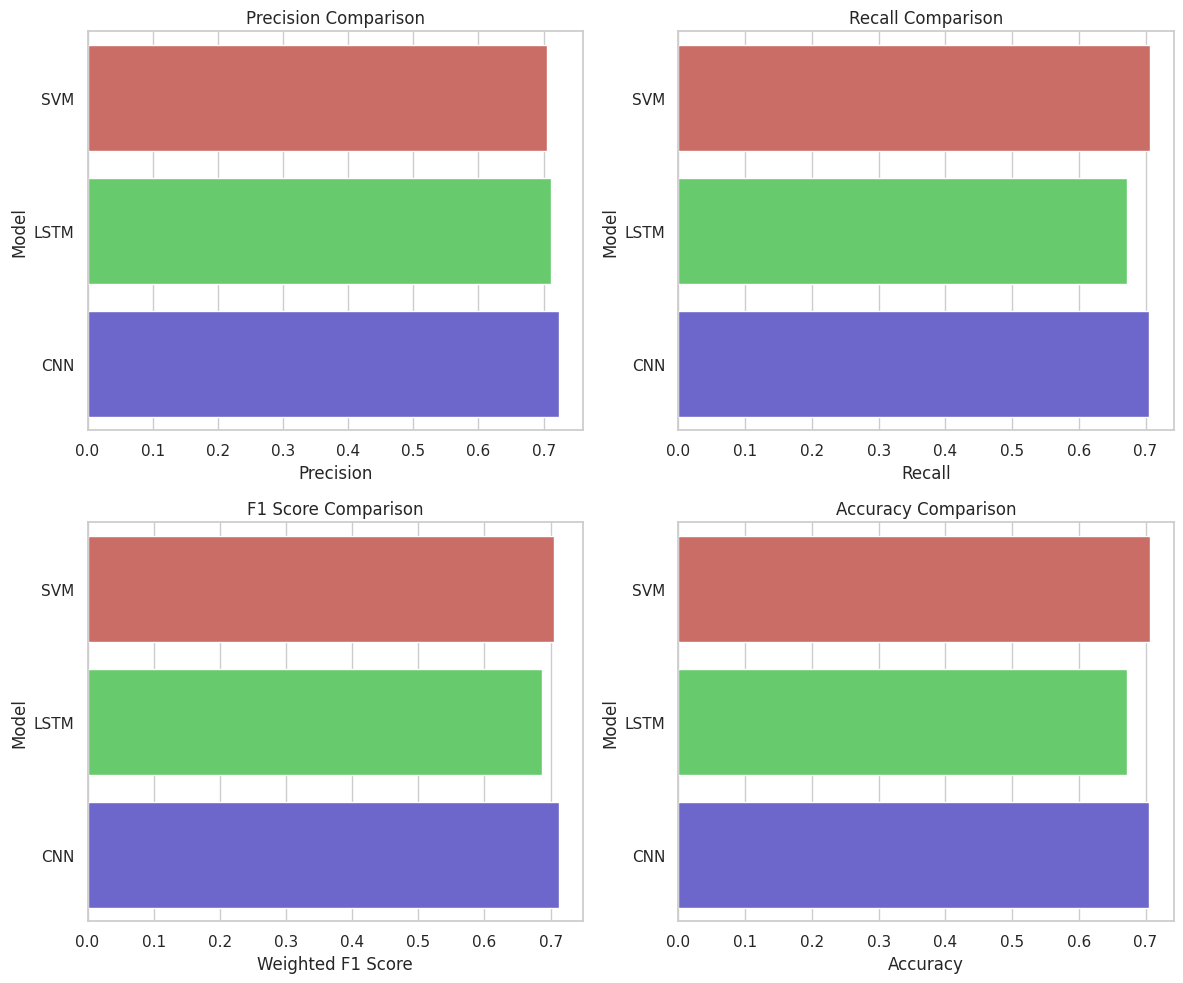

In [ ]:
metrics_df= pd.DataFrame({'Model': ['SVM', 'LSTM', 'CNN'],
                   'Precision': [precision_svm, precision_lstm, precision_cnn],
                   'Recall': [recall_svm, recall_lstm, recall_cnn],
                   'Weighted F1 Score': [f1_svm, f1_lstm, f1_cnn],
                   'Accuracy': [accuracy_svm, accuracy_lstm, accuracy_cnn]})

sns.set(style="whitegrid")

# Use 'Model' as hue and set legend to False
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

sns.barplot(x='Precision', y='Model', data=metrics_df, ax=axes[0, 0], hue='Model', palette='hls', legend=False)
axes[0, 0].set_title('Precision Comparison')

sns.barplot(x='Recall', y='Model', data=metrics_df, ax=axes[0, 1], hue='Model', palette='hls', legend=False)
axes[0, 1].set_title('Recall Comparison')

sns.barplot(x='Weighted F1 Score', y='Model', data=metrics_df, ax=axes[1, 0], hue='Model', palette='hls', legend=False)
axes[1, 0].set_title('F1 Score Comparison')

sns.barplot(x='Accuracy', y='Model', data=metrics_df, ax=axes[1, 1], hue='Model', palette='hls', legend=False)
axes[1, 1].set_title('Accuracy Comparison')

plt.tight_layout()
plt.show()

In [ ]:

new_sentence = "This is an great place"
extracted_sentiment_terms = extract_pos_tags_as_string(new_sentence)
aspect_terms = get_nouns(new_sentence)


new_sentence = new_sentence + extracted_terms


new_sentence_seq = tokenizer.texts_to_sequences(new_sentence)
new_sentence_padded = pad_sequences(new_sentence_seq, maxlen=max_sequence_length)


new_sentence_probabilities = model.predict(new_sentence_padded)
new_sentence_label = np.argmax(new_sentence_probabilities, axis=1)

print(f'Predicted Label: {new_sentence_label[0]}')


new_sentence_seq = tokenizer_aspect.texts_to_sequences([aspect_terms[0]])
new_sentence_padded = pad_sequences(new_sentence_seq, maxlen=max_sequence_length)


new_sentence_probabilities = aspect_category_model.predict(new_sentence_padded)
new_sentence_label = np.argmax(new_sentence_probabilities, axis=1)

predicted_category = label_encoder_aspect.inverse_transform(new_sentence_label)

print(f'Predicted Aspect Category: {predicted_category[0]}')



1/1 [==============================] - 0s 20ms/step
Predicted Label: 1
1/1 [==============================] - 0s 19ms/step
Predicted Aspect Category: Ambiance
